In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

np.random.seed(42)

In [ ]:
# ============================================================================
# 1. DATASET GENERATION
# ============================================================================

print("="*70)
print("GENERATING SYNTHETIC DATASET")
print("="*70)

# Generate 5-class synthetic dataset
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                           n_classes=5, n_clusters_per_class=1, random_state=42)

# One-hot encode labels
def one_hot_encode(y, n_classes):
    one_hot = np.zeros((len(y), n_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

Y = one_hot_encode(y, 5)

# Train/test split
X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(
    X, Y, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features, 5 classes")
print(f"Train: {len(X_train)}, Test: {len(X_test)}\n")

GENERATING SYNTHETIC DATASET
Dataset: 2000 samples, 20 features, 5 classes
Train: 1600, Test: 400



In [ ]:

# ============================================================================
# 2. NEURAL NETWORK CLASS
# ============================================================================

class ThreeHiddenLayerNN:
    """
    Neural Network with 3 Hidden Layers for Multi-Class Classification
    Architecture: Input → Hidden1(64) → Hidden2(32) → Hidden3(16) → Output(5)
    Activation: ReLU (hidden), Softmax (output)
    Loss: Categorical Cross-Entropy
    """

    def __init__(self, input_size, output_size, lr=0.01):
        self.lr = lr

        # Initialize weights with He initialization
        self.W1 = np.random.randn(input_size, 64) * np.sqrt(2.0/input_size)
        self.b1 = np.zeros((1, 64))

        self.W2 = np.random.randn(64, 32) * np.sqrt(2.0/64)
        self.b2 = np.zeros((1, 32))

        self.W3 = np.random.randn(32, 16) * np.sqrt(2.0/32)
        self.b3 = np.zeros((1, 16))

        self.W4 = np.random.randn(16, output_size) * np.sqrt(2.0/16)
        self.b4 = np.zeros((1, output_size))

        self.loss_history = []
        self.acc_history = []

    def relu(self, x, der=False):
        """ReLU: f(x)=max(0,x), f'(x)=1 if x>0 else 0"""
        return np.where(x > 0, 1, 0) if der else np.maximum(0, x)

    def softmax(self, x):
        """Softmax: exp(x_i)/sum(exp(x_j))"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        """Forward propagation"""
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.relu(self.z3)

        self.z4 = self.a3.dot(self.W4) + self.b4
        self.output = self.softmax(self.z4)
        return self.output

    def backward(self, X, Y):
        """Backpropagation"""
        m = X.shape[0]

        # Output layer gradient (softmax + cross-entropy)
        dz4 = self.output - Y
        dW4 = self.a3.T.dot(dz4) / m
        db4 = np.sum(dz4, axis=0, keepdims=True) / m

        # Hidden layer 3
        da3 = dz4.dot(self.W4.T)
        dz3 = da3 * self.relu(self.z3, der=True)
        dW3 = self.a2.T.dot(dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        # Hidden layer 2
        da2 = dz3.dot(self.W3.T)
        dz2 = da2 * self.relu(self.z2, der=True)
        dW2 = self.a1.T.dot(dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        # Hidden layer 1
        da1 = dz2.dot(self.W2.T)
        dz1 = da1 * self.relu(self.z1, der=True)
        dW1 = X.T.dot(dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights
        self.W4 -= self.lr * dW4; self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3; self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2; self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1; self.b1 -= self.lr * db1

    def train(self, X, Y, epochs=1000):
        """Train the network"""
        for epoch in range(epochs):
            pred = self.forward(X)

            # Calculate loss and accuracy
            loss = -np.sum(Y * np.log(pred + 1e-15)) / len(Y)
            acc = np.mean(np.argmax(pred, axis=1) == np.argmax(Y, axis=1))

            self.loss_history.append(loss)
            self.acc_history.append(acc)

            self.backward(X, Y)

            if epoch % 100 == 0 or epoch == epochs-1:
                print(f"Epoch {epoch:4d}/{epochs} - Loss: {loss:.4f} - Acc: {acc:.4f}")

    def predict(self, X):
        """Predict class labels"""
        return np.argmax(self.forward(X), axis=1)

    def predict_proba(self, X):
        """Predict probabilities"""
        return self.forward(X)


In [ ]:
# ============================================================================
# 3. TRAINING
# ============================================================================

print("="*70)
print("TRAINING NEURAL NETWORK")
print("="*70)
print("Architecture: 20 → 64 → 32 → 16 → 5")
print("Activation: ReLU (hidden), Softmax (output)")
print("Loss: Categorical Cross-Entropy\n")

nn = ThreeHiddenLayerNN(input_size=20, output_size=5, lr=0.01)
nn.train(X_train, Y_train, epochs=1000)

TRAINING NEURAL NETWORK
Architecture: 20 → 64 → 32 → 16 → 5
Activation: ReLU (hidden), Softmax (output)
Loss: Categorical Cross-Entropy

Epoch    0/1000 - Loss: 4.0280 - Acc: 0.1825
Epoch  100/1000 - Loss: 1.0220 - Acc: 0.6094
Epoch  200/1000 - Loss: 0.7649 - Acc: 0.7312
Epoch  300/1000 - Loss: 0.6150 - Acc: 0.7987
Epoch  400/1000 - Loss: 0.5160 - Acc: 0.8306
Epoch  500/1000 - Loss: 0.4471 - Acc: 0.8544
Epoch  600/1000 - Loss: 0.3957 - Acc: 0.8750
Epoch  700/1000 - Loss: 0.3570 - Acc: 0.8869
Epoch  800/1000 - Loss: 0.3259 - Acc: 0.8956
Epoch  900/1000 - Loss: 0.2995 - Acc: 0.9031
Epoch  999/1000 - Loss: 0.2767 - Acc: 0.9081


In [ ]:
# ============================================================================
# 4. EVALUATION
# ============================================================================

print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)

y_pred = nn.predict(X_test)
y_pred_proba = nn.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"\nTest Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print(f"Macro F1-Score: {f1_macro:.4f}\n")

print("Per-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*50)
for i in range(5):
    print(f"Class {i}   {precision[i]:.4f}       {recall[i]:.4f}       {f1[i]:.4f}")
print(f"Macro    {precision_macro:.4f}       {recall_macro:.4f}       {f1_macro:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(5)]))



EVALUATION RESULTS

Test Accuracy: 0.8650 (86.50%)
Macro F1-Score: 0.8651

Per-Class Metrics:
Class    Precision    Recall       F1-Score    
--------------------------------------------------
Class 0   0.8400       0.7875       0.8129
Class 1   0.8889       0.9114       0.9000
Class 2   0.9231       0.9000       0.9114
Class 3   0.8861       0.8642       0.8750
Class 4   0.7931       0.8625       0.8263
Macro    0.8662       0.8651       0.8651

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.79      0.81        80
     Class 1       0.89      0.91      0.90        79
     Class 2       0.92      0.90      0.91        80
     Class 3       0.89      0.86      0.88        81
     Class 4       0.79      0.86      0.83        80

    accuracy                           0.86       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.86      0.87       400



GENERATING VISUALIZATIONS


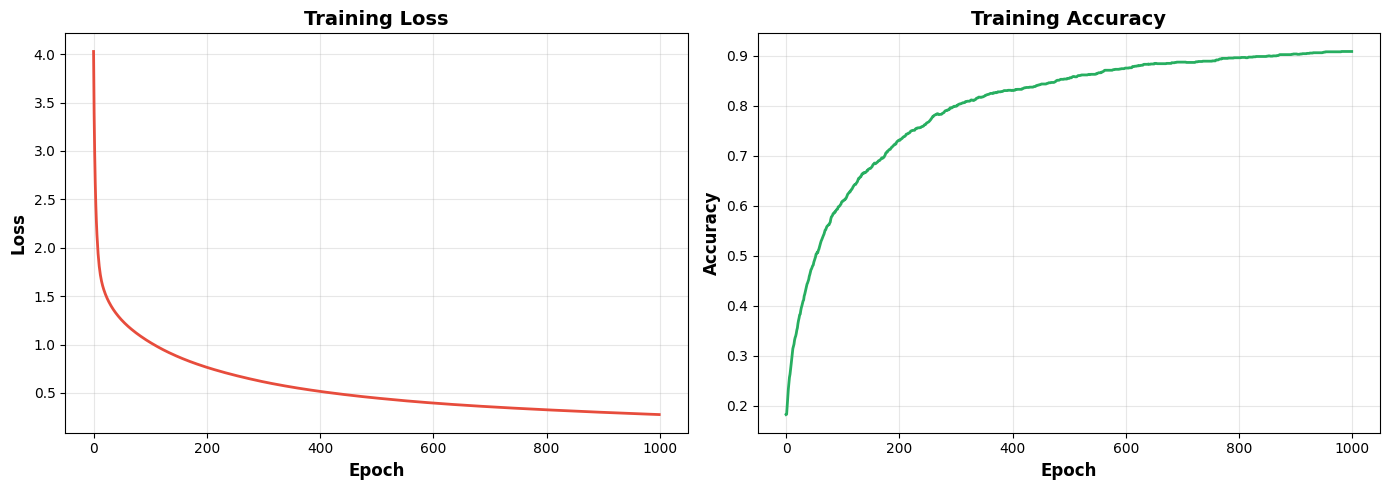

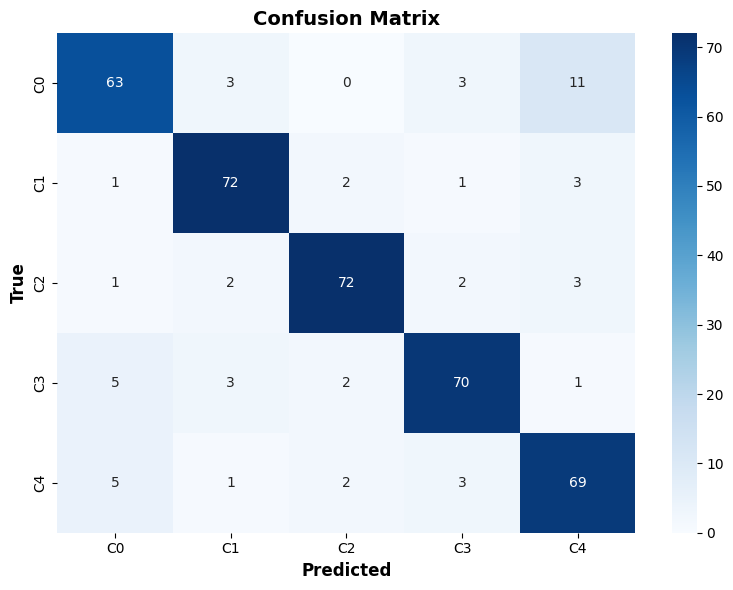

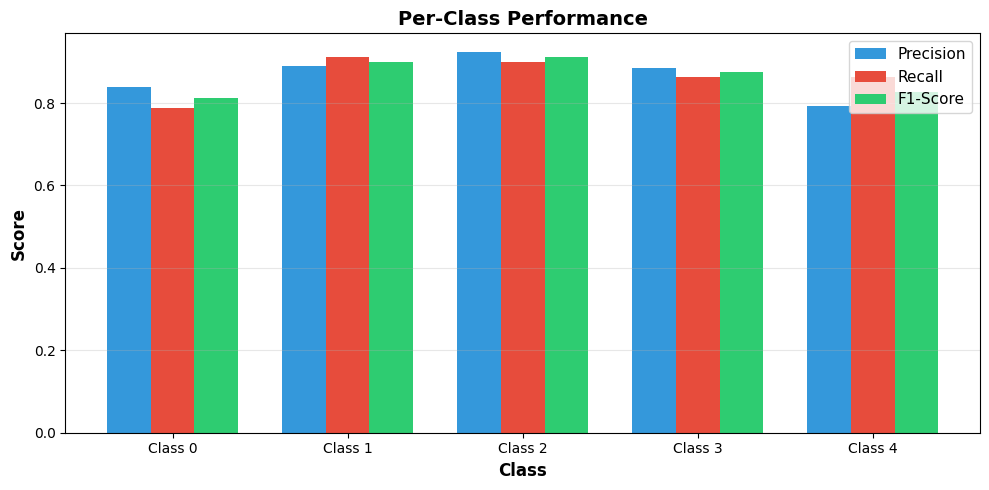

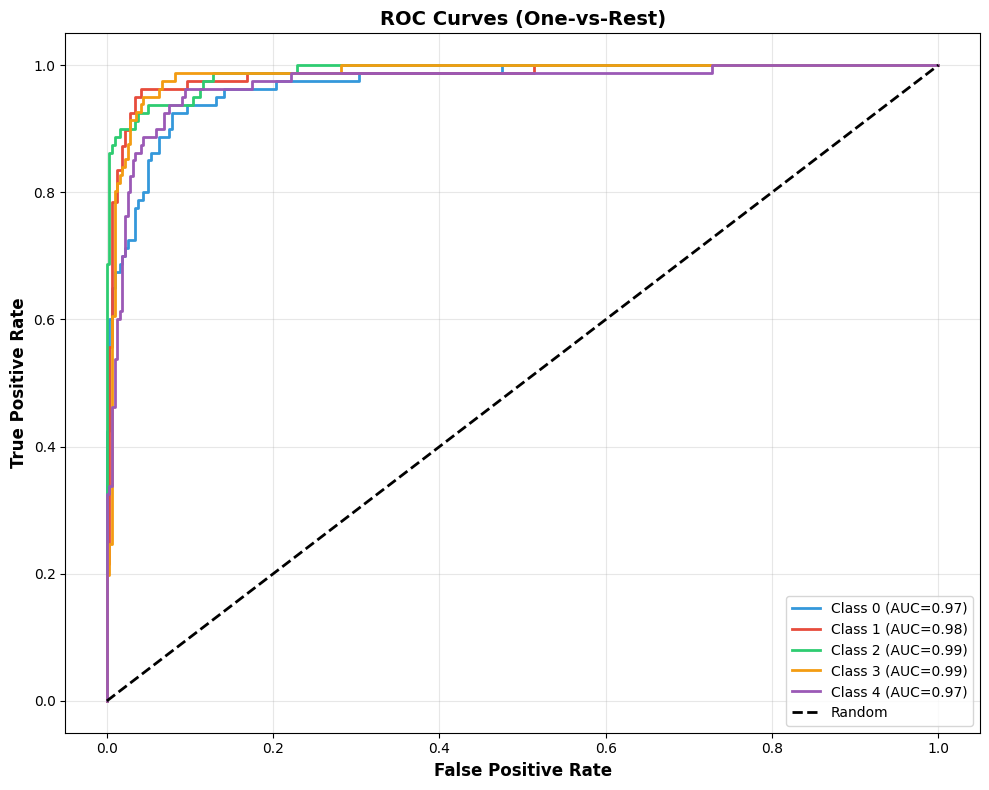

In [ ]:
# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

print("="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(nn.loss_history, linewidth=2, color='#E74C3C')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(nn.acc_history, linewidth=2, color='#27AE60')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Training Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(5)],
            yticklabels=[f'C{i}' for i in range(5)])
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class performance
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(5)
width = 0.25

ax.bar(x - width, precision, width, label='Precision', color='#3498DB')
ax.bar(x, recall, width, label='Recall', color='#E74C3C')
ax.bar(x + width, f1, width, label='F1-Score', color='#2ECC71')

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Class {i}' for i in range(5)])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ROC curves
Y_test_bin = label_binarize(y_test, classes=range(5))
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10, 8))
colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']

for i, color in enumerate(colors):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 6. ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("ANALYSIS AND OBSERVATIONS")
print("="*70)

print("\n1. Performance:")
print(f"   • Test accuracy: {acc*100:.2f}%")
print(f"   • Macro F1-score: {f1_macro:.4f}")
print(f"   • Best class: Class {np.argmax(f1)} (F1={f1.max():.4f})")
print(f"   • Worst class: Class {np.argmin(f1)} (F1={f1.min():.4f})")

print("\n2. Architecture:")
print("   • 3 hidden layers (64→32→16) successfully implemented")
print("   • ReLU prevents vanishing gradient")
print("   • Softmax provides probability distribution")

print("\n3. Challenges Solved:")
print("   • Used He initialization for better convergence")
print("   • Numerical stability in softmax (subtract max)")
print("   • Simplified gradient: softmax+cross-entropy → (pred-true)")

print("\n4. Potential Improvements:")
print("   • Add dropout for regularization")
print("   • Implement Adam optimizer")
print("   • Use learning rate decay")
print("   • Try batch normalization")




ANALYSIS AND OBSERVATIONS

1. Performance:
   • Test accuracy: 86.50%
   • Macro F1-score: 0.8651
   • Best class: Class 2 (F1=0.9114)
   • Worst class: Class 0 (F1=0.8129)

2. Architecture:
   • 3 hidden layers (64→32→16) successfully implemented
   • ReLU prevents vanishing gradient
   • Softmax provides probability distribution

3. Challenges Solved:
   • Used He initialization for better convergence
   • Numerical stability in softmax (subtract max)
   • Simplified gradient: softmax+cross-entropy → (pred-true)

4. Potential Improvements:
   • Add dropout for regularization
   • Implement Adam optimizer
   • Use learning rate decay
   • Try batch normalization
